In [3]:
import matplotlib
from scipy.stats import poisson
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import trange 

In [4]:
class CarRental:
    def __init__(self):
        self.max_cars = 20
        self.max_move_cars = 5
        self.rent_req_loc1 = 3
        self.rent_req_loc2 = 3
        self.ret_loc1 = 3
        self.ret_loc2 = 2
        self.discount = 0.9
        self.rent_credit = 10
        self.move_car_cost = 2
        self.actions = np.arange(-self.max_move_cars, self.max_move_cars + 1)
        self.truncate = 11
        self.values = np.zeros((self.max_cars + 1, self.max_cars + 1))
        self.policy = np.zeros(self.values.shape, dtype=np.int)
        self.poisson_prob_dict = dict()


    def compPoissonProb(self,n, lam):
        key = n * 10 + lam
        if key not in self.poisson_prob_dict:
            self.poisson_prob_dict[key] = poisson.pmf(n, lam)
        return self.poisson_prob_dict[key]

    def getValues(self):
        return self.values

    def getPolicy(self):
        return self.policy

    def solveBellman(self,state, action, state_value, const_ret_cars = True):

        returns = 0.0

        returns -=  self.move_car_cost* abs(action)


        for req_loc1 in range(self.truncate):
            for req_loc2 in range(self.truncate):

                prob = self.compPoissonProb(req_loc1, self.rent_req_loc1) * \
                    self.compPoissonProb(req_loc2, self.rent_req_loc2)

                num_cars_loc1, num_cars_loc2 = min(state[0] - action, self.max_cars), min(state[1] + action, self.max_cars)

                rental_loc1, rental_loc2 = min(num_cars_loc1, req_loc1), min(num_cars_loc2, req_loc2)


                reward = (rental_loc1 + rental_loc2) * self.rent_credit
                
                num_cars_loc1 -= rental_loc1
                num_cars_loc2 -= rental_loc2

                if const_ret_cars:
                    ret_cars_loc1 = self.ret_loc1
                    ret_cars_loc2 = self.ret_loc2
                    num_cars_loc1 = min(num_cars_loc1 + ret_cars_loc1, self.max_cars)
                    num_cars_loc2 = min(num_cars_loc2 + ret_cars_loc2, self.max_cars)
                    returns += prob * (reward + self.discount * state_value[num_cars_loc1, num_cars_loc2])
        return returns


    def policyEvaluation(self,value,policy):
        while True:
                old_value = value.copy()
                for i in range(self.max_cars + 1):
                    for j in range(self.max_cars + 1):
                        new_state_value = self.solveBellman([i, j], policy[i, j], value)
                        value[i, j] = new_state_value
                max_delta = abs(old_value - value).max()
                print(f'max value change {max_delta}')
                if max_delta < 1e-4:
                    break

        return value 

    def policyImprovement(self,policy,value):
        policy_stable = True
        for i in range(self.max_cars + 1):
            for j in range(self.max_cars + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in self.actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(self.solveBellman([i, j], action, value))
                    else:
                        action_returns.append(-np.inf)
                new_action = self.actions[np.argmax(action_returns)]
                policy[i, j] = new_action
                if policy_stable and old_action != new_action:
                    policy_stable = False
        print(f'policy stable {policy_stable}')
        return policy, policy_stable


    def figure_4_2(self,const_ret_cars=True):
        iter_cnt = 0
        
        _, axes = plt.subplots(2, 3, figsize=(40, 20))
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        axes = axes.flatten()
        
        while True:
            fig = sns.heatmap(np.flipud(self.policy), cmap="YlGnBu", ax=axes[iter_cnt])
            fig.set_ylabel('# cars at first location', fontsize=30)
            fig.set_yticks(list(reversed(range(self.max_cars + 1))))
            fig.set_xlabel('# cars at second location', fontsize=30)
            fig.set_title('policy {}'.format(iter_cnt), fontsize=30)

            self.values = self.policyEvaluation(self.values,self.policy)

            # policy improvement
            self.policy, policy_stable = self.policyImprovement(self.policy,self.values)

            if policy_stable:
                fig = sns.heatmap(np.flipud(self.values), cmap="YlGnBu", ax=axes[-1])
                fig.set_ylabel('# cars at first location', fontsize=30)
                fig.set_yticks(list(reversed(range(self.max_cars + 1))))
                fig.set_xlabel('# cars at second location', fontsize=30)
                fig.set_title('optimal value', fontsize=30)
                break

            iter_cnt += 1
        print('iterations:',iter_cnt+1)
        #plt.savefig('../images/figure_4_2.png')
        #plt.close()
        plt.show()



max value change 140.60068276451554
max value change 103.25877249659266
max value change 79.54555567437669
max value change 62.45772254224954
max value change 50.669837686516416
max value change 42.36952738188012
max value change 35.008148822699184
max value change 28.708337982268745
max value change 23.449798881011247
max value change 20.06374287814708
max value change 17.30261307783053
max value change 14.888360048625827
max value change 12.78895633883775
max value change 10.970520166501274
max value change 9.40000639626021
max value change 8.04657697818243
max value change 6.882213227553052
max value change 5.88188779828738
max value change 5.023491432037872
max value change 4.287635230543287
max value change 3.6574002804696306
max value change 3.1180748273381482
max value change 2.6568998622143454
max value change 2.262832871020919
max value change 1.9263334585830307
max value change 1.6391714512848239
max value change 1.394256576824489
max value change 1.1854881556188275
max value

max value change 9.124506158286749e-05
policy stable False
max value change 0.018965476355106148
max value change 0.003423377541935224
max value change 0.0012829126067117613
max value change 0.0007574680968218672
max value change 0.0005084521632170436
max value change 0.0003573754341914537
max value change 0.0002585314996395027
max value change 0.00019112685311029054
max value change 0.00014341470125600608
max value change 0.0001100277053183163
max value change 8.44641562025572e-05
policy stable True
iterations: 5


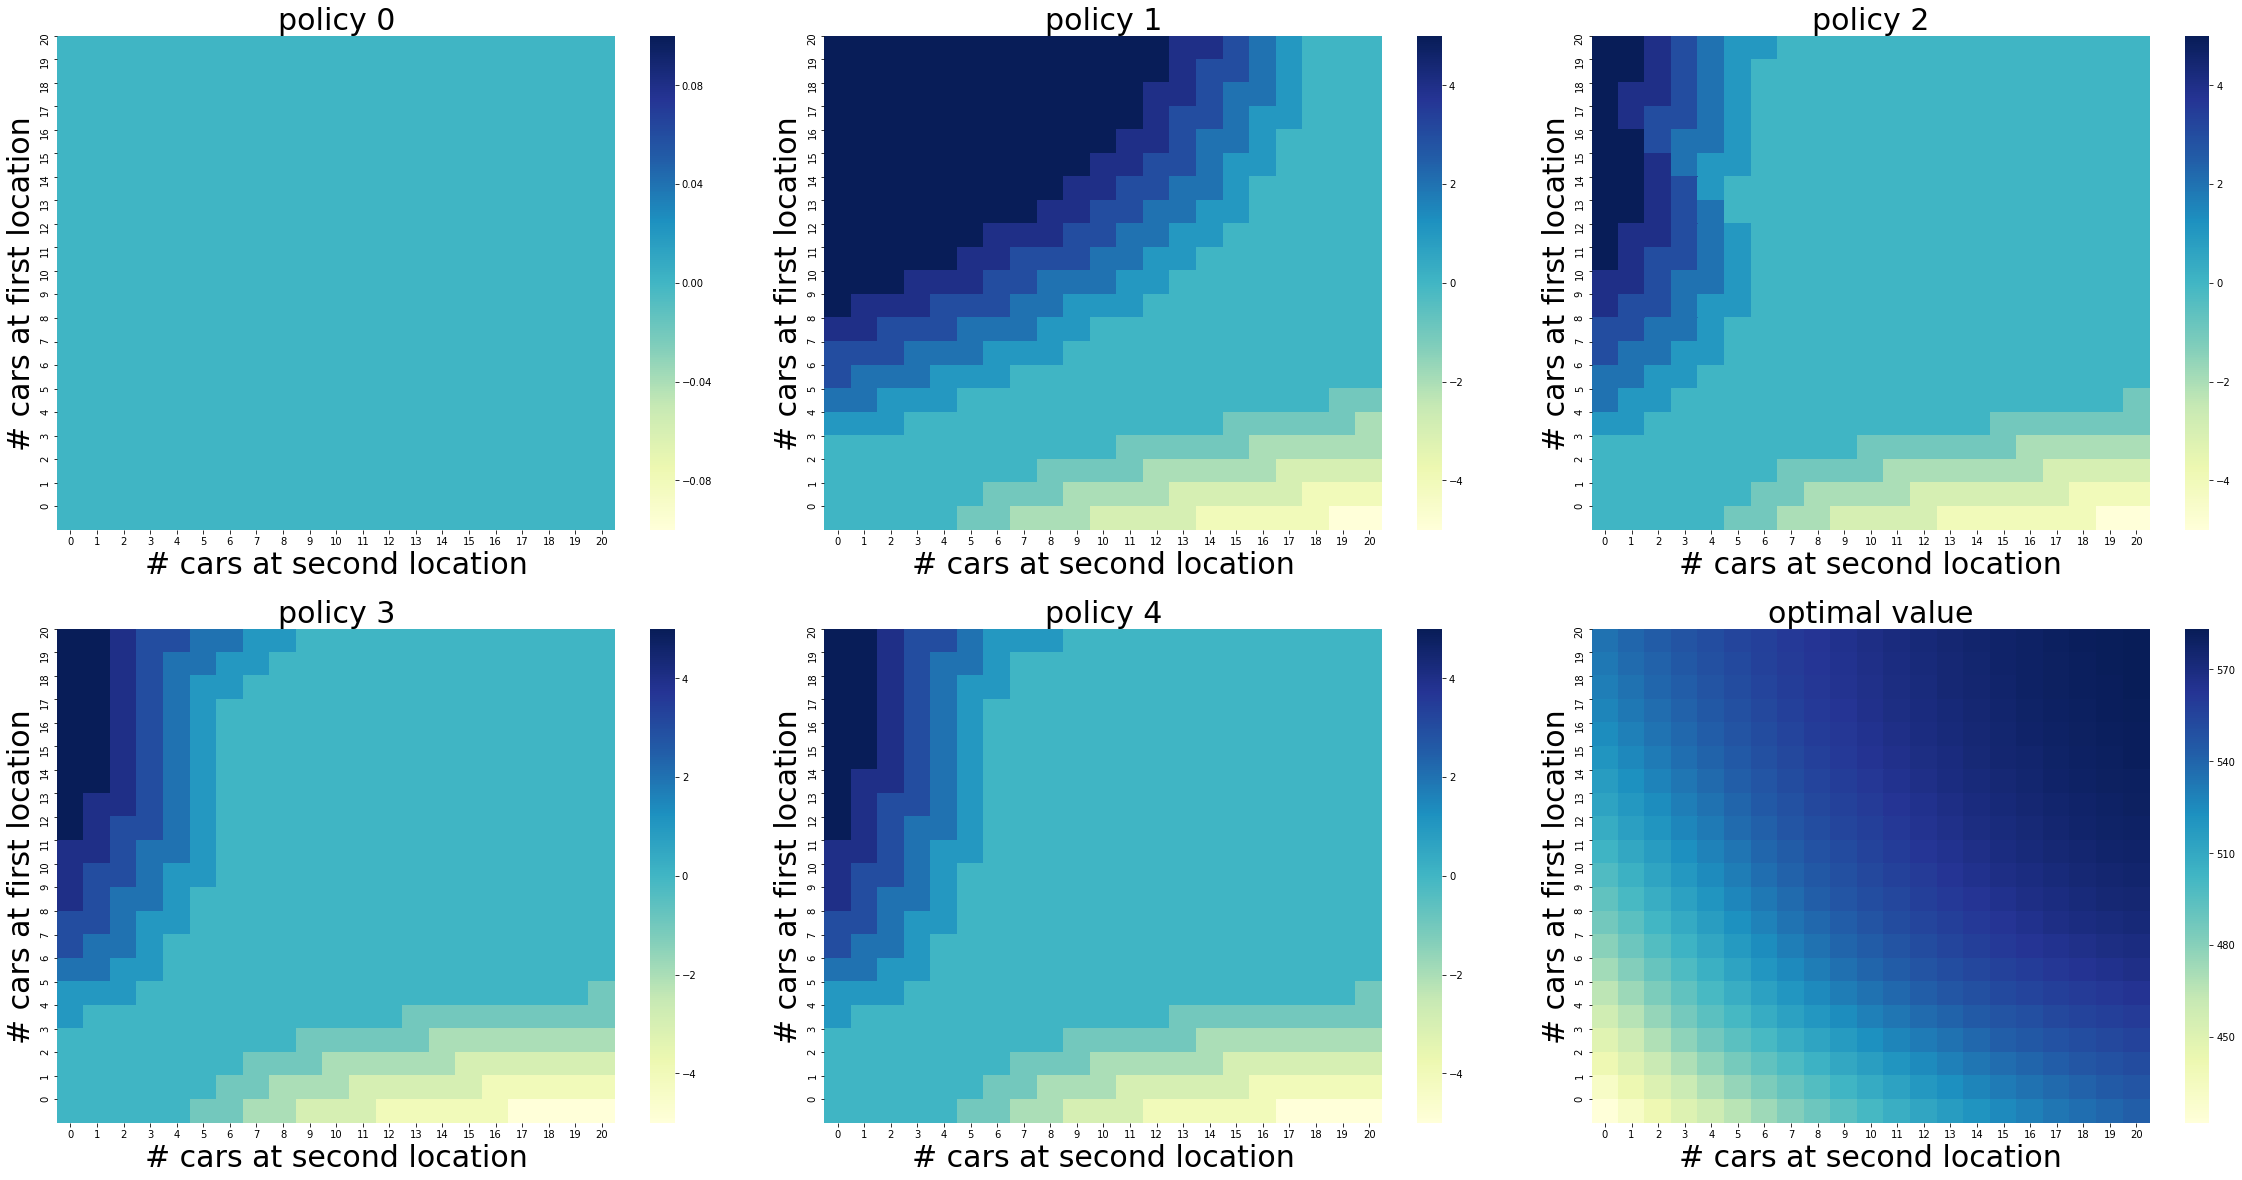

In [5]:
car = CarRental()
car.figure_4_2()
